In [1]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import scipy.signal as sig
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0


# Enable importing from modules in top-level directory
from sys import path
if path[0] != '..': path.insert(0, '..')

%matplotlib widget

<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Discrete Convolution

* **Course AIS2201 - Signalbehandling**
* **Week 42, 2025**
* **Lecturer: Kai Erik Hoff**


# Topics

* Digital filters as a concept
* Desired properties (LTI)
* Discrete LTI-systems (the difference equation)
* IIR filters summarized
    * Exponential averager is a IIR filter
    * Digital IIR filters created by discretizing continuous systems
* FIR filters
    * Coefficients = impulse response
    * Filtering = convolving impulse respone & signal

# Recap: What is a FIR filter?


 


* **FIR** - **F**inite **I**mpulse **R**esponse

* Describes a digital filter which calculates the output $y[n]$ based *only* on a linear combination of the input values $x[n]$ at various sample times.

* Difference equation for FIR filters:
### $$ y[n] = \sum_{k=0}^{N} b_k \cdot x[n-k]$$

* Filter properties described by the filter coefficients $b_k$

* $N$ denotes the *filter order*
    * Determines how many samples "back in time" the FIR filter needs to keep samples in the buffer.

* Mathematically much simpler to work with than a IIR filter

* Capable of obtaining properties which are *not* possible for physical/continuous-time systems.

# Recap: FIR filter system diagram


<br>
<img src="figures/tapped_delay_line.svg" style="width: 75%; margin-left: 100px" />




* FIR filters commonly referred to as *tapped delay line* filters

* Number of "taps" ($M=N+1$) are a more common metric for size of filter than the filter order

# Digital filter properties: *The Impulse Response*



<img src="figures/impulse_response.svg" style="width: 60%; margin-left: 200px" />

* The mathematical properties of a digital filter which is both linear and time-invariant are contained entirely within it's impulse response.

<!--
* Premiss for LTI-system:
    * *Dersom systemets reaksjon til en deltapuls $\delta[n]$ er kjent, er det mulig å predikere hvordan systemet vil reagere på alle mulige inngangssignal.*
* Utgangssignalet til et LTI-system gitt en impuls $\delta[n]$ som inngangssignal kalles impulsresponsen $h[n]$ til systemet.
-->

* Python example generating and displaying the impulse response $h[n]$ for an $M$-point moving average filter

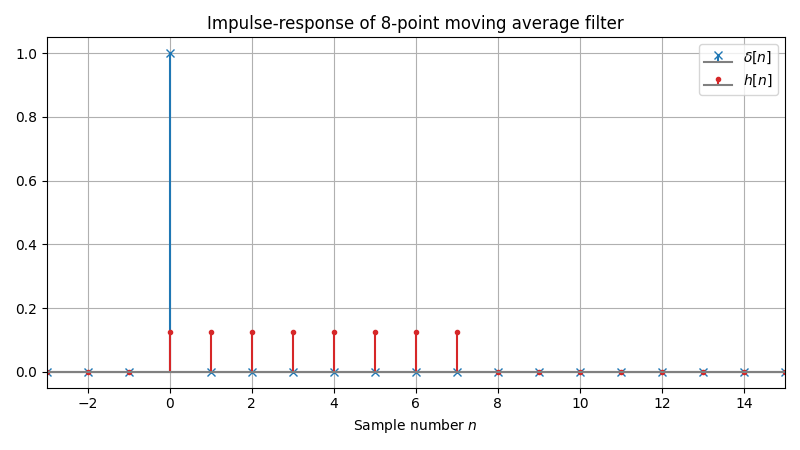

In [2]:
def moving_average_filt(x, M):
    """
    Function to perform M-point moving average filtering of a signal array 'x'
    """
    y = [np.sum(x[n:max(n-M,0):-1])/M for n in range(len(x))]
    return np.array(y)

n = np.arange(-3, 16) # Sample -3 <= n < 16
dn = np.where(n==0, 1, 0) # Delta pulse
M = 8
hn = moving_average_filt(dn, M)

plt.close(1); plt.figure(1);
plt.stem(n, dn, markerfmt='x', basefmt="grey", label="$\\delta[n]$")
plt.stem(n, hn, markerfmt='.C3', linefmt='C3', basefmt="grey", label="$h[n]$")
plt.legend()
plt.xlabel("Sample number $n$")
plt.title(f"Impulse-response of {M}-point moving average filter");

# Designing/analyzing FIR filters



<img src="figures/impulse_response.svg" align="right" width="25%" style="margin-right:100px"/>

<div style="width: 50%"><ul><li> Working with FIR filters involves analyzing/shaping the <i>Impulse Response</i> of the FIR filter.</li></ul></div>


* The impulse response of a FIR filter **very** is easily acquired.
    * This is in contrast to IIR filters where calculating the impulse response is highly cumbersome, and not generally relevant when analyzing IIR filters.

# FIR filters impulse response

\begin{align}
h[n] &= \sum_{k=0}^{M} b_k \cdot \delta[n-k]\\
     &= b_0 \cdot \delta[n] + b_1\cdot \delta[n-1] + \ldots + b_M\cdot \delta[n-M]\\ \\
     &= \begin{cases} b_k \big|_{k=n}, & 0 \leq n \leq M \\ 0, & \text{otherwise} \end{cases}
\end{align}



* The impulse response of a FIR filter is a signal which contains each filter coefficient $b_k$ in turn.

| $$n$$ | $$ n < 0 $$ | $$0$$ | $$1$$ | $$2$$ | $$3$$ | $$\ldots$$ | $$N$$ | $$N+1$$ | $$n > N +1 $$ |
|---|---|---|---|---|---|---|---|---|---|
|$$x[n] = \delta[n]$$ | $$0$$ | $$1$$ |  $$0$$ | $$0$$ | $$0$$ | $$0$$ | $$0$$ | $$0$$ | $$0$$ |
|$$y[n] = h[n]$$ |$$0$$ | $$b_0$$ | $$b_1$$ | $$b_2$$ | $$b_3$$ | $$\ldots$$ | $$b_N$$ | $$0$$ | $$0$$|

## Question
* What is the impulse respone $h[n]$ of the following filter?

$$ y[n] = \frac{1}{4} x[n] + \frac{1}{2}x[n-1] + \frac{1}{4}x[n-2]$$

# Why the impulse response $h[n]$ of a filter is important


1. Any signal can be decomposed into a sum of scaled and shifted deltapulses.

$$x[n] = \sum_{k=0}^{\infty} x[k] \cdot \delta[n-k]$$



2. The properties of *linearity* and *time-invariance* imply that the ouputput of a LTI-system can be expressed as a sum of scaled and shifted *impulse responses*.
\begin{align}
y[n] &= F(x[n])\\
     &= F\left(\sum_{k=-\infty}^{\infty} x[k]\cdot \delta[n-k]\right)\\
     &= \sum_{k=-\infty}^{\infty} x[k]\cdot F(\delta[n-k])\\
     &= \sum_{k=-\infty}^{\infty} x[k]\cdot h[n-k]
\end{align}

# Convolution

* The output of a LTI-ystem can be calucated by ***convolving*** the input signal $x[n]$ with the system's impulse response $h[n]$.
    * Convolution operator: $*$

\begin{align}
y[n] &= \sum_{k=-\infty}^{\infty} x[k]\cdot h[n-k]\\
&= x[n]*h[n]
\end{align}

* Using convolution to calculate the output of a IIR filter is not practical
    * The impulse response $h[n]$ of an IIR filter is infinitely long, resulting in an infinite number of calculations

* FIR filters are filters which in practice perform convolution
    * The impulse response and the filter coefficients are the same array of numbers

## Demo: Filtrering av signal med konvolusjon

Output()

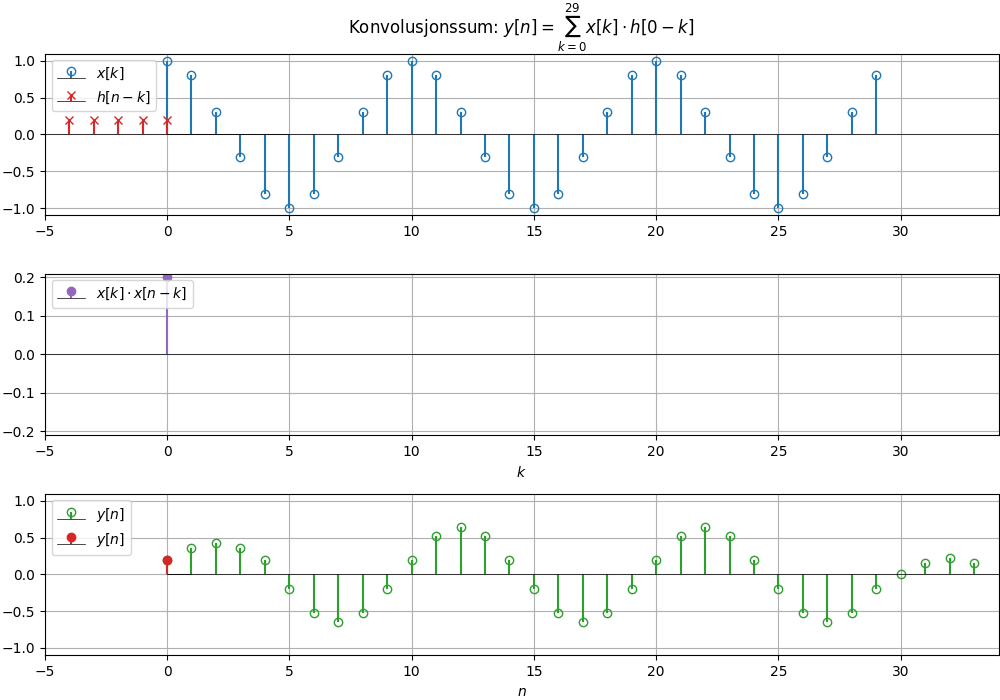

In [3]:
from demos import ConvolutionDemo
n = np.arange(30); xn = np.cos(pi/5*n) # Sinussekvens
hn =  np.array(np.ones(5)/5)                      # 
ConvolutionDemo(xn, hn, fig_num=2,figsize=(10,7));    #

* Convolution step-by-step:
    1. Flip the impulse response $h[n]$ aboug $n=0$ (time-reversal)
    2. Calculate the product sum where the signal $x[n]$ overlaps with the flipped impulse response $h[-n]$
    3. Shift the flipped impulse response one step along the $x$-axis
    4. Repeat step 2 & 3 as long as there are overlapping samples
 
* You are encouraged to used try out the demo with various input signals and impulse responses

## Observations

* Output signal length equals the sum of input signal length and impulse response length minus 1:
$$L_y = L_x + M-1$$

* The digital filter has a "response time", and the waveform of the filtered signal will typically lag behind the input signal.

# Calculating convolution

* When calculating by hand, the simplest approach is to use a multiplication table
<br>
<br>

<div>
<img src="figures/ConvIllustration1.png" style="width:43%; align:left; margin-left:100px"/>
</div>

# Calculating convolution

* When calculating by hand, the simplest approach is to use a multiplication table
* The convolution result is found by adding up the products along each diagonal

<img src="figures/ConvIllustration2.png" style="width:65%; align:left; margin-left:100px"/>

## Programming example: *create a function to calculate convolution "from scratch"*

$$ y[n] = \sum_{k=0}^{\infty}x[k]\cdot h[n-k]$$


In [ ]:
def convolve(x, h):
    
    M = len(h)  # Number of filter "taps"
    L_x = len(x)  # Length of input signal
    L_y = M + L_x -1   # Length of filtered signal
    y = np.zeros(L_y)  # "Empty" output signal
    
    for n in range(L_y):  # For each sample in the output y[n]
        for k in range(M):  # For each "tap" in the filter
            if 0 <= n - k < M:  # If x[k] overlaps with h[n-k]
                y[n] += x[k]*h[n-k]
    return y

x = np.ones(10)
h = np.ones(5)
convolve(x, h)

# Convolution using python

* The `numpy` module has a function  [`convolve()`](https://numpy.org/doc/2.0/reference/generated/numpy.convolve.html).

In [ ]:
xn = np.ones(20) # x[n] = u[n]-u[n-10]
hn = np.array([1, -1, 2, -1, 1]) # Fra regneeksempel 2
yn = np.convolve(xn, hn)
yn = yn[:20]
plt.close(3);plt.figure(3, figsize=(8,3))
plt.stem(yn)

# Step response

* The step response $s[n]$ of of a filter $h[n]$ is defined as the output signal $y[n]$ when the input $x[n]$ is a [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) $u[n]$




$$s[n] = h[n]*u[n]$$

* Equivalent to the running sum of the impulse response: $$s[n] = \sum_{k=0}^n h[k]$$


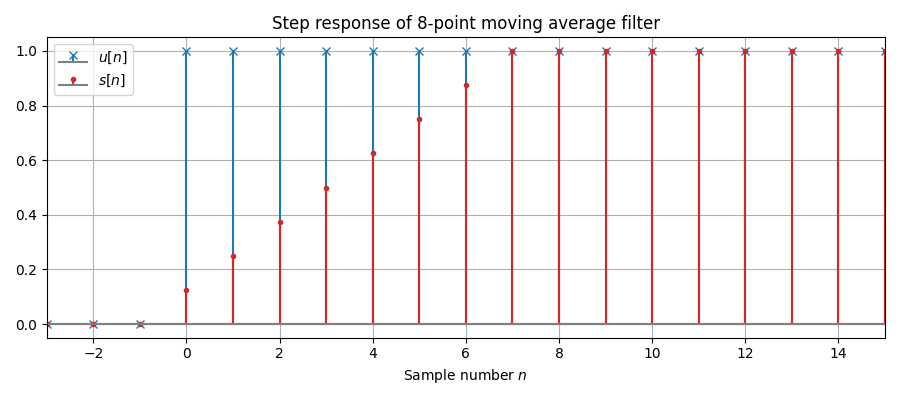

In [9]:
def moving_average_filt(x, M):
    """
    Function to perform M-point moving average filtering of a signal array 'x'
    """
    y = [np.sum(x[n:max(n-M,0):-1])/M for n in range(len(x))]
    return np.array(y)

n = np.arange(-3, 16) # Sample -3 <= n < 16
un = np.where(n>=0, 1, 0) # Delta pulse
M = 8
sn = moving_average_filt(un, M)

plt.close(1); plt.figure(1, figsize=(9, 4));
plt.stem(n, un, markerfmt='x', basefmt="grey", label="$u[n]$")
plt.stem(n, sn, markerfmt='.C3', linefmt='C3', basefmt="grey", label="$s[n]$")
plt.legend()
plt.xlabel("Sample number $n$")
plt.title(f"Step response of {M}-point moving average filter");

## Regneeksempel 2:
* Calculate the step response of the filter
$$h[n] = \delta[n]-\delta[n-1]+2\delta[n-2]-\delta[n-3]+\delta[n-4]$$

# Convolution in image processing: *edge detection*

* Simple FIR filters such as a first order difference filter *can* be used to highlight edges in images
    * $h[n] = \delta[n] - \delta[n-1]$
    
#### Below we can see a grayscale image, as well as an intensity profile from one row in the image.

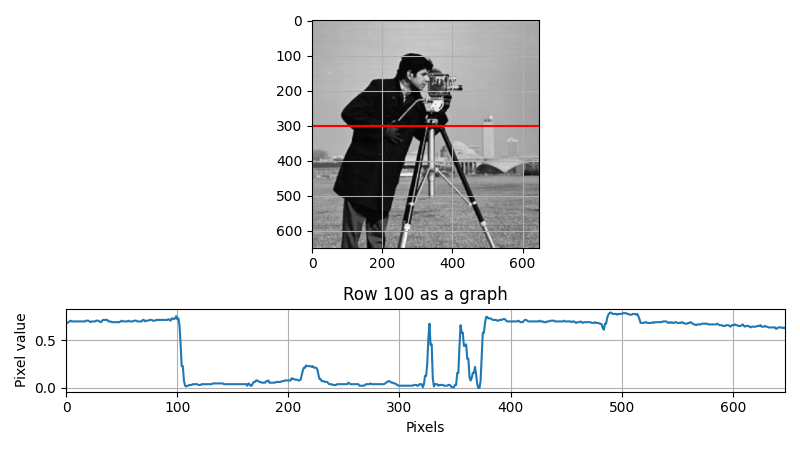

In [10]:
Im = plt.imread("figures/camera.png")
Im = Im[:,:,0]  # Extract grayscale image as 2D array
plt.figure()
plt.subplot(3,1,(1,2))
plt.imshow(Im, cmap="gray")
rows, cols = Im.shape
plt.plot([0, cols-1], [300, 300], 'r')
plt.subplot(3,1,3)
plt.plot(Im[300,:])
plt.title("Row 100 as a graph")
plt.xlabel('Pixels')
plt.ylabel('Pixel value')
plt.tight_layout()

### We can use the difference filter to filter each pixel row/column individually

Text(0.5, 1.0, 'Vertical difference filter')

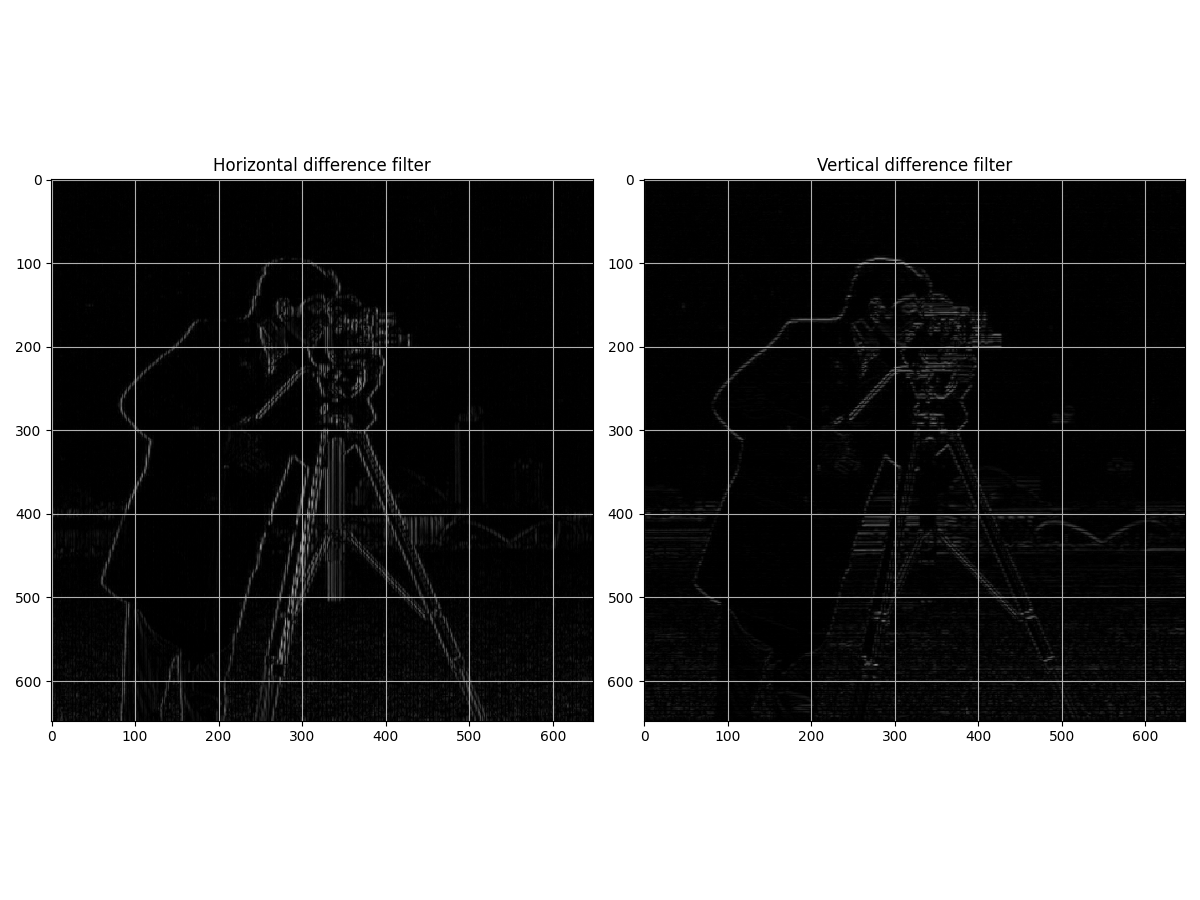

In [11]:
h = np.array([1, -1])
h_hori = h.reshape(1, 2)  # Single row, two columns
h_vert = h.reshape(2, 1)  # Single column, two rows

# Filter image in each direction
Im_filt_h = sig.convolve2d(Im, h_hori, mode="same")
Im_filt_v = sig.convolve2d(Im, h_vert, mode="same")

# Plot the result
plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.imshow(abs(Im_filt_h), cmap="gray")
plt.title("Horizontal difference filter")
plt.subplot(1,2,2)
plt.imshow(abs(Im_filt_v), cmap="gray")
plt.title("Vertical difference filter")

#### Notes:

Notice the use of convolution `mode="same"` to ensure image dimensions remain unchanged through filtering.

### Combine the two images. 

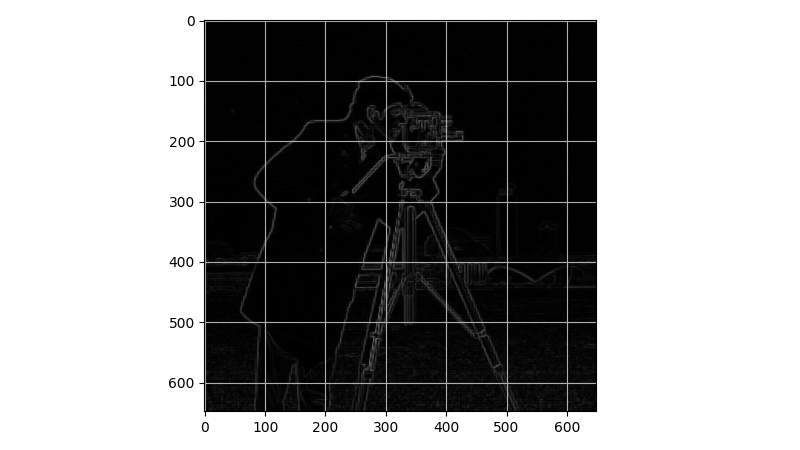

In [12]:
Im_filt = np.sqrt(Im_filt_h**2 + Im_filt_v**2)
plt.figure()
plt.imshow(np.abs(Im_filt), cmap="gray")

### Use thresholding to create a binary image showing the location of edges

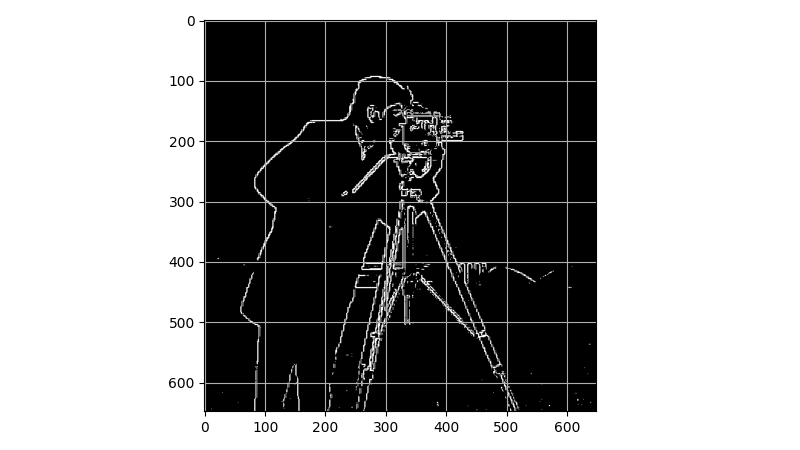

In [13]:
threshold = 0.15
Im_edges = Im_filt > threshold*np.max(Im_filt)
plt.figure()
plt.imshow(np.abs(Im_edges), cmap="gray")

# Convolution properties


In [19]:
from numpy import convolve as conv
# Test signals for illustrative purposes
xn = np.array([1, 1, -1, -1]) # y[n]
yn = np.array([1, -1, 1, -1]) # y[n]
vn = np.array([1, 2, 1]) # v[n]

1. Commutative
\begin{align}
x[n]*y[n] &= y[n]*x[n] \\
\sum_{k=-\infty}^{\infty} x[k]\cdot y[n-k] &= \sum_{k=-\infty}^{\infty} y[k]\cdot x[n-k]
\end{align}

In [20]:
print(conv(xn, yn))
print(conv(yn, xn))

[ 1  0 -1  0 -1  0  1]
[ 1  0 -1  0 -1  0  1]


2. Associative
$$(x[n]*y[n])*v[n] = x[n]*(y[n]*v[n])$$

In [22]:
print(conv(conv(xn, yn), vn)) # (x[n]*y[n])*v[n]
print(conv(xn, conv(yn, vn))) # x[n]*(y[n]*v[n])

[ 1  2  0 -2 -2 -2  0  2  1]
[ 1  2  0 -2 -2 -2  0  2  1]



3. Distributive *(linearity)*
$$(x[n] + y[n])*v[n] = x[n]*v[n] + y[n]*v[n]$$

In [23]:
print(conv(xn + yn, vn)) # (x[n] + y[n])*v[n]
print(conv(xn, vn) + conv(yn, vn)) # x[n]*v[n] + y[n]*v[n]

[ 2  4  2 -2 -4 -2]
[ 2  4  2 -2 -4 -2]


4. Convolution and the frequency domain
\begin{align*}
x[n] * y[n] &\leftrightarrow X\left(\hat{\omega} \right)\cdot Y\left(\hat{\omega} \right) \\
x[n]\cdot y[n] &\leftrightarrow X\left(\hat{\omega} \right) * Y\left(\hat{\omega} \right)
\end{align*}
    * *More on this next week!*

# FIR filters in parallell

* A combination of two FIR filters in parallell can be described as **one** overall FIR filter

<div>
<img src="figures/parallell.svg" style="width:70%, margin-left:100px"/>
</div>

* Impulse response $h_P$ for combined system is sum of component impulse responses (distributive property):

$$ h_P[n] = h_A[n] + h_B[n]$$

# Cascaded FIR filters

* Order of filter operations ambiguous due associative property
<br>
<div>
<img src="figures/cascade.svg" style="width:70%, margin-left:100px"/>
</div>


* Impulse response $h_C[n]$ for cascaded system is found by *convolving* component impulse responses:

$$h_C[n] = h_A[n]*h_B[n]$$

## Example:

* Given the following:
    1. We wish to differentiate an input signal $x[n]$
        * Can be accomplished with a first order difference filter: $h_1[n] = (\delta[n] - \delta[n-1])\cdot \frac{1}{T_s}$
    2. $x[n]$ is noisy, and we are primarily interested in *consistent* changes in the values of $x[n]$.
        * High frequency noise is amplified by a difference filter.
    3. A suggested solution is to use a *moving average filter* of length $M=6$ taps to filter the signal $x[n]$ before differentiation.
        * The result is a cascaded moving average filter and first order difference filter.
<br><br>
* Find the impulse response of the full system $h_{\text{tot}}[n]$.



# Summary

* Digital filters use a linear combination of available signal samples ($x[n-k] \big/ y[n-k]$) recorded in memory to calculate the next output $y[n]$ for each sample.
* The mathematical properties of a *Linear*, and *Time-invariant* system can be inferred from it's *impulse response* $h[n]$.
* The output $y[n]$ for a LTI-system is calculated by *convolving* the input $x[n]$ and the impulse response $h[n]$:
$$y[n] = \sum_{k=0}^{\infty} x[k] \cdot h[n-k] = x[n]*h[n]$$
* FIR filters are *"convolution machines"*
    * A LTI-system which ***only*** uses previous imput samples ($x[n-k]$) to calculate the output $y[n]$
        * $y[n] = b_0 \cdot x[n] + b_1 \cdot x[n-1] + \ldots + b_N \cdot x[n-N]$
    * The impulse response $h[n]$ is simply the a signal containing each filter coefficient $b_k$ in turn.
* Two LTI-systems in cascade will have a total impulse response $h[n] = h_A[n] * h_B[n]$
* Two LTI-systems in parallell will have a total impulse respones $h[n] = h_A[n] + h_B[n]$